Disease Classification from Symptom Data

In [53]:
import pandas as pd
import numpy as np 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# OR specifically suppress Streamlit warnings:
import logging
logging.getLogger('streamlit').setLevel(logging.ERROR)


In [54]:
import pandas as pd

# Load datasets from current working directory
train_path = 'Training.csv'
test_path = 'Testing.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Display data info
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print(train.head())


Training set shape: (4920, 134)
Test set shape: (42, 133)
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  scurring  \
0       0           0             0        0                 0  ...         0   
1       0           0             0        0                 0  ...         0   
2       0           0             0        0                 0  ...         0   
3       0           0             0        0                 0  ...         0   
4       0           0             0        0                 0

In [55]:
train.head()
test.head()


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


In [56]:
train.tail()
test.tail()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
37,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary tract infection
39,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis
40,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,Impetigo
41,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,Fungal infection


In [57]:
# Remove unnamed columns
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

# Check for missing values
print(train.isnull().sum())
print(test.isnull().sum())

# Remove duplicates
train = train.drop_duplicates()
test = test.drop_duplicates()

print("Data cleaned successfully!")


itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64
itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64
Data cleaned successfully!


In [58]:
def add_features(df):
    # Total symptom count
    symptom_cols = [col for col in df.columns if col != 'prognosis']
    df['symptom_sum'] = df[symptom_cols].sum(axis=1)
    
    # Respiratory group
    respiratory_cols = ['cough', 'high_fever', 'runny_nose', 'sinus_pressure', 'congestion']
    group_cols = [col for col in respiratory_cols if col in df.columns]
    if group_cols:
        df['respiratory_sum'] = df[group_cols].sum(axis=1)
    
    return df

train = add_features(train)
test = add_features(test)

print("Features engineered!")


Features engineered!


In [59]:
from sklearn.preprocessing import LabelEncoder

# Extract labels
y_train_raw = train['prognosis']
y_test_raw = test['prognosis']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_raw)
y_test_enc = le.transform(y_test_raw)

print(f"Classes: {le.classes_}")
print(f"Encoded y_train: {y_train_enc[:5]}")


Classes: ['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy' 'Arthritis' 'Bronchial Asthma'
 'Cervical spondylosis' 'Chicken pox' 'Chronic cholestasis' 'Common Cold'
 'Dengue' 'Diabetes ' 'Dimorphic hemmorhoids(piles)' 'Drug Reaction'
 'Fungal infection' 'GERD' 'Gastroenteritis' 'Heart attack' 'Hepatitis B'
 'Hepatitis C' 'Hepatitis D' 'Hepatitis E' 'Hypertension '
 'Hyperthyroidism' 'Hypoglycemia' 'Hypothyroidism' 'Impetigo' 'Jaundice'
 'Malaria' 'Migraine' 'Osteoarthristis' 'Paralysis (brain hemorrhage)'
 'Peptic ulcer diseae' 'Pneumonia' 'Psoriasis' 'Tuberculosis' 'Typhoid'
 'Urinary tract infection' 'Varicose veins' 'hepatitis A']
Encoded y_train: [15 15 15 15 15]


In [60]:
# Separate features and labels
X_train_full = train.drop(columns=['prognosis'])
X_test_full = test.drop(columns=['prognosis'])

print(f"X_train_full shape: {X_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}")


X_train_full shape: (304, 134)
X_test_full shape: (42, 134)


In [61]:
from sklearn.model_selection import train_test_split

# Split: 70% train, 15% validation, 15% test
X_main, X_test_split, y_main, y_test_split = train_test_split(
    X_train_full, y_train_enc, test_size=0.15, stratify=y_train_enc, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.1765, stratify=y_main, random_state=42)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test_split.shape}")


X_train: (212, 134), X_val: (46, 134), X_test: (46, 134)


In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_split)
X_test_full_scaled = scaler.transform(X_test_full)

print("Features scaled successfully!")


Features scaled successfully!


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Random Forest (no scaling)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# SVM (scaled)
svc_model = SVC(kernel='rbf', random_state=42)
svc_model.fit(X_train_scaled, y_train)

# Logistic Regression (scaled)
logreg_model = LogisticRegression(max_iter=200, random_state=42)
logreg_model.fit(X_train_scaled, y_train)

print("All models trained successfully!")


All models trained successfully!


In [64]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_svc = svc_model.predict(X_val_scaled)
y_val_pred_logreg = logreg_model.predict(X_val_scaled)

# Validation Accuracy
print("=" * 50)
print("VALIDATION RESULTS")
print("=" * 50)
print(f"Random Forest: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"SVM: {accuracy_score(y_val, y_val_pred_svc):.4f}")
print(f"Logistic Regression: {accuracy_score(y_val, y_val_pred_logreg):.4f}")

# Choose best model (e.g., Random Forest if highest accuracy)
print("\nBest model: Random Forest")
best_model = rf_model


VALIDATION RESULTS
Random Forest: 1.0000
SVM: 1.0000
Logistic Regression: 1.0000

Best model: Random Forest


TEST SET RESULTS
Test Accuracy: 1.0000

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         2
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold      

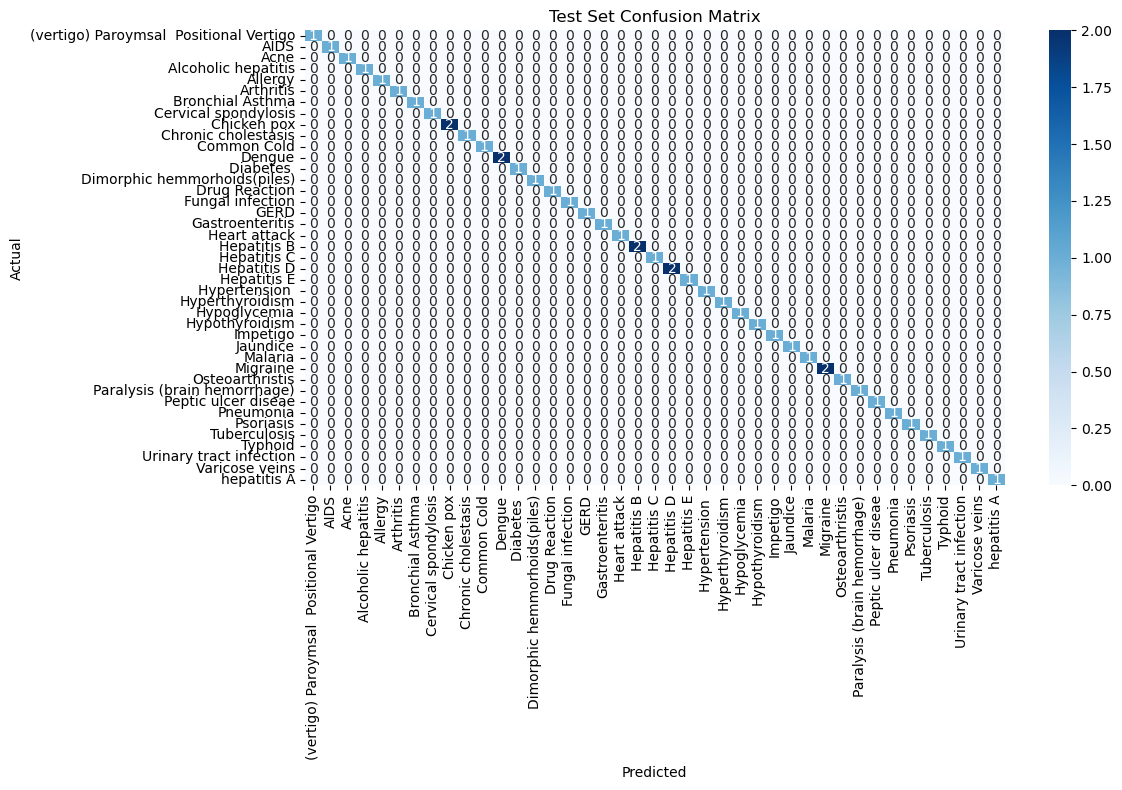

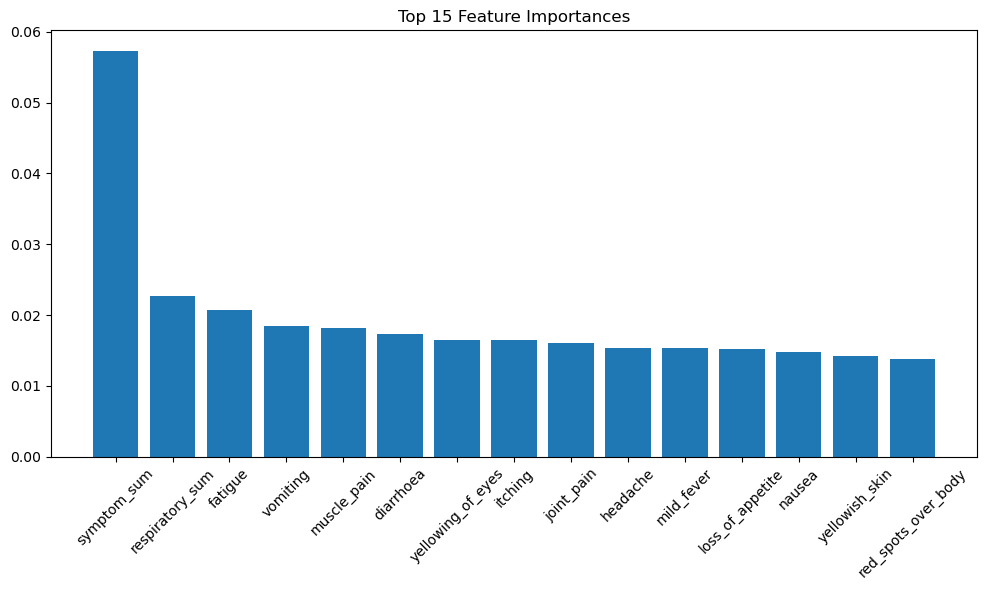

In [65]:
# Test predictions
y_test_pred = best_model.predict(X_test_split)

# Test Metrics
print("=" * 50)
print("TEST SET RESULTS")
print("=" * 50)
print(f"Test Accuracy: {accuracy_score(y_test_split, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_split, y_test_pred, target_names=le.classes_))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_split, y_test_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature Importance
importances = best_model.feature_importances_
indices = importances.argsort()[::-1][:15]

plt.figure(figsize=(10, 6))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=45)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Load your training data if not already loaded
train = pd.read_csv('Training.csv')

# Remove any unnamed columns (recommended)
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]

# Prepare features DataFrame
X_train_full = train.drop(columns=['prognosis'])

# Now get symptom columns
symptom_cols = X_train_full.columns.tolist()


In [15]:
symptom_cols = X_train_full.columns.tolist()


In [16]:
user_input = [
    1,  # itching
    0,  # skin_rash
    0,  # nodal_skin_eruptions
    1,  # continuous_sneezing
    1,  # shivering
    0,  # chills
    1,  # joint_pain
    1,  # stomach_pain
    0,  # acidity
    0,  # ulcers_on_tongue
    0,  # muscle_wasting
    1,  # vomiting
    0,  # burning_micturition
    1,  # spotting_urination
    # ... continue for all symptoms in the dataset!
]


In [20]:
import pandas as pd
import numpy as np
import joblib

# Load model, scaler, and label encoder (if not already loaded)
model = joblib.load('disease_model.pkl')
scaler = joblib.load('scaler.pkl')
le = joblib.load('label_encoder.pkl')

# Get symptom columns
train = pd.read_csv('Training.csv')
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
symptom_cols = [col for col in train.columns if col != 'prognosis']

# User input example (must match order and number!)
user_input = [
    1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1  # Expand to your full symptom list!
]

# Step 1: Convert and scale
symptoms_arr = np.array(user_input).reshape(1, -1)
symptoms_scaled = scaler.transform(symptoms_arr)

# Step 2: Predict disease
label_encoded = model.predict(symptoms_scaled)[0]
predicted_disease = le.inverse_transform([label_encoded])[0]
print("Predicted Disease:", predicted_disease)

# Step 3: Show probabilities
probs = model.predict_proba(symptoms_scaled)[0]
for label, prob in zip(le.classes_, probs):
    print(f"{label}: {prob*100:.2f}%")


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 14 features, but StandardScaler is expecting 134 features as input.